In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

os.chdir('/content/drive/MyDrive/Seed_Classification_4_varieties/crease_up')
os.getcwd()

'/content/drive/MyDrive/Seed_Classification_4_varieties/crease_up'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn.over_sampling as oversample
from model import *
from train_eval import *
import torch
from torchsummary import summary
import torch.optim as optim
import pickle
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
# re-structuring data for training machine-learning model
# combining (train, validation) then applying balancing techniques

if not os.path.exists('Data/combined_df_tr_imbalanced.csv'):

    df_tr = pd.read_csv('Data/df_tr_imbalanced.csv')
    df_val = pd.read_csv('Data/df_val.csv')

    df_train = pd.concat([df_tr, df_val], axis=0)
    df_train = df_train.reset_index(drop=True)
    df_train.to_csv(f'Data/combined_df_tr_imbalanced.csv', index=False)
    print(df_train.shape)

    # apply smote
    X, y = df_train.iloc[:, :-1], df_train.iloc[: , -1]


    # applying smote
    oversampler = oversample.SMOTE()
    X_smote, Y_smote = oversampler.fit_resample(X, y)

    df_tr_smote = pd.concat([X_smote, Y_smote], axis=1)
    df_tr_smote.to_csv('Data/combined_df_tr_smote.csv', index = False)

    # applying Adasyn
    oversampler = oversample.ADASYN()
    X_adasyn, Y_adasyn = oversampler.fit_resample(X, y)

    df_tr_adasyn = pd.concat([X_adasyn, Y_adasyn], axis=1)
    df_tr_adasyn.to_csv('Data/combined_df_tr_adasyn.csv', index = False)


## Data-Processing

In [ ]:
if not os.path.exists('Data/df_tr_smote.csv'):
  df_tr_imbalanced = pd.read_csv('Data/df_tr_imbalanced.csv')
  X, y = df_tr_imbalanced.iloc[:, :-1], df_tr_imbalanced.iloc[: , -1]


  # applying smote
  oversampler = oversample.SMOTE()
  X_smote, Y_smote = oversampler.fit_resample(X, y)

  df_tr_smote = pd.concat([X_smote, Y_smote], axis=1)
  df_tr_smote.to_csv('Data/df_tr_smote.csv', index = False)

  # applying Adasyn
  oversampler = oversample.ADASYN()
  X_adasyn, Y_adasyn = oversampler.fit_resample(X, y)

  df_tr_adasyn = pd.concat([X_adasyn, Y_adasyn], axis=1)
  df_tr_adasyn.to_csv('Data/df_tr_adasyn.csv', index = False)

  print('Imbalanced : ', df_tr_imbalanced.shape)
  print('Smote balanced : ', df_tr_smote.shape)
  print('Adasyn balanced : ', df_tr_adasyn.shape)

In [ ]:
config = {
    'BATCH_SIZE' : 32,
    'lr' : 0.00005,
    'EPOCHS' : 50,
    'input_size' : 147,
    'output_size' : 4,

    'val_path' : 'Data/df_val.csv',
    'tst_path' : 'Data/df_tst.csv' ,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df_tst = pd.read_csv(config['tst_path'])

## Setting Training

In [ ]:
model = CNN1D(config['output_size']).to(device)
summary(model, (config['input_size'],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1               [-1, 1, 147]               2
            Conv1d-2              [-1, 32, 145]             128
             PReLU-3              [-1, 32, 145]               1
         MaxPool1d-4               [-1, 32, 72]               0
           Conv_1D-5               [-1, 32, 72]               0
       BatchNorm1d-6               [-1, 32, 72]              64
            Conv1d-7               [-1, 64, 34]          10,304
             PReLU-8               [-1, 64, 34]               1
         MaxPool1d-9               [-1, 64, 17]               0
          Conv_1D-10               [-1, 64, 17]               0
      BatchNorm1d-11               [-1, 64, 17]             128
           Conv1d-12               [-1, 128, 7]          41,088
            PReLU-13               [-1, 128, 7]               1
        MaxPool1d-14               [-1,

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
criterion = nn.CrossEntropyLoss()    # weight = class_weights.to(device)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5,cooldown= 2, factor = 0.4, verbose = True, threshold = 1e-2)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## Plotting

In [ ]:
def plot_history(history:dict, model_name):
      plt.figure( figsize=(20,10))

    #   plt.subplot(2, 1, 1)
      plt.plot(history['train_loss'], 'o-', color='green')
      plt.plot(history['val_loss'], 'o-', color='red')
      plt.plot(history['train_acc'], 'o-', color='pink')
      plt.plot(history['val_acc'], 'o-', color='blue')
    #   plt.ylabel('Loss')
      plt.xlabel('Epochs', fontsize = 14)
      plt.legend(['Train Loss' , 'Validation Loss','Train Accuracy' , 'Validation Accuracy'],  fontsize = 14)


      plt.savefig('{x}_Train_Val_Curves.png'.format(x = model_name), bbox_inches='tight')


## Imbalanced Data Training

In [ ]:
config['tr_path'] = 'Data/df_tr_imbalanced.csv'
config['name'] = 'imbalanced'

df_tr = pd.read_csv(config['tr_path'])

y = np.array(df_tr.iloc[:, -1])


mean = torch.tensor(np.mean(df_tr.iloc[: ,:-1], axis=0), dtype = torch.float32)
std = torch.tensor(np.std(df_tr.iloc[: ,:-1], axis=0) , dtype = torch.float32)
print(mean.shape , std.shape)

torch.Size([147]) torch.Size([147])


In [ ]:
if not os.path.exists('imbalanced_model.pt'):
  tr_dataset = MyDataset(path =config ['tr_path'] , mean = mean ,std = std , apply_transform = True)
  tr_loader = DataLoader(tr_dataset, batch_size=config['BATCH_SIZE'], shuffle=True)

  val_dataset = MyDataset(path = config['val_path'] , mean = mean ,std = std, apply_transform = True)
  val_loader = DataLoader(val_dataset, batch_size=config['BATCH_SIZE'], shuffle=True)

  X,Y = next(iter(tr_loader))
  print(X.shape , Y.shape)

  obj = Train_Eval(model=model, model_name=config['name'] ,device=device ,train_loader=tr_loader,
                 val_loader=val_loader, optimizer=optimizer, criterion=criterion, lr_scheduler= lr_scheduler)
  obj.run(config['EPOCHS'])
  obj.eval(df_tst, mean, std)


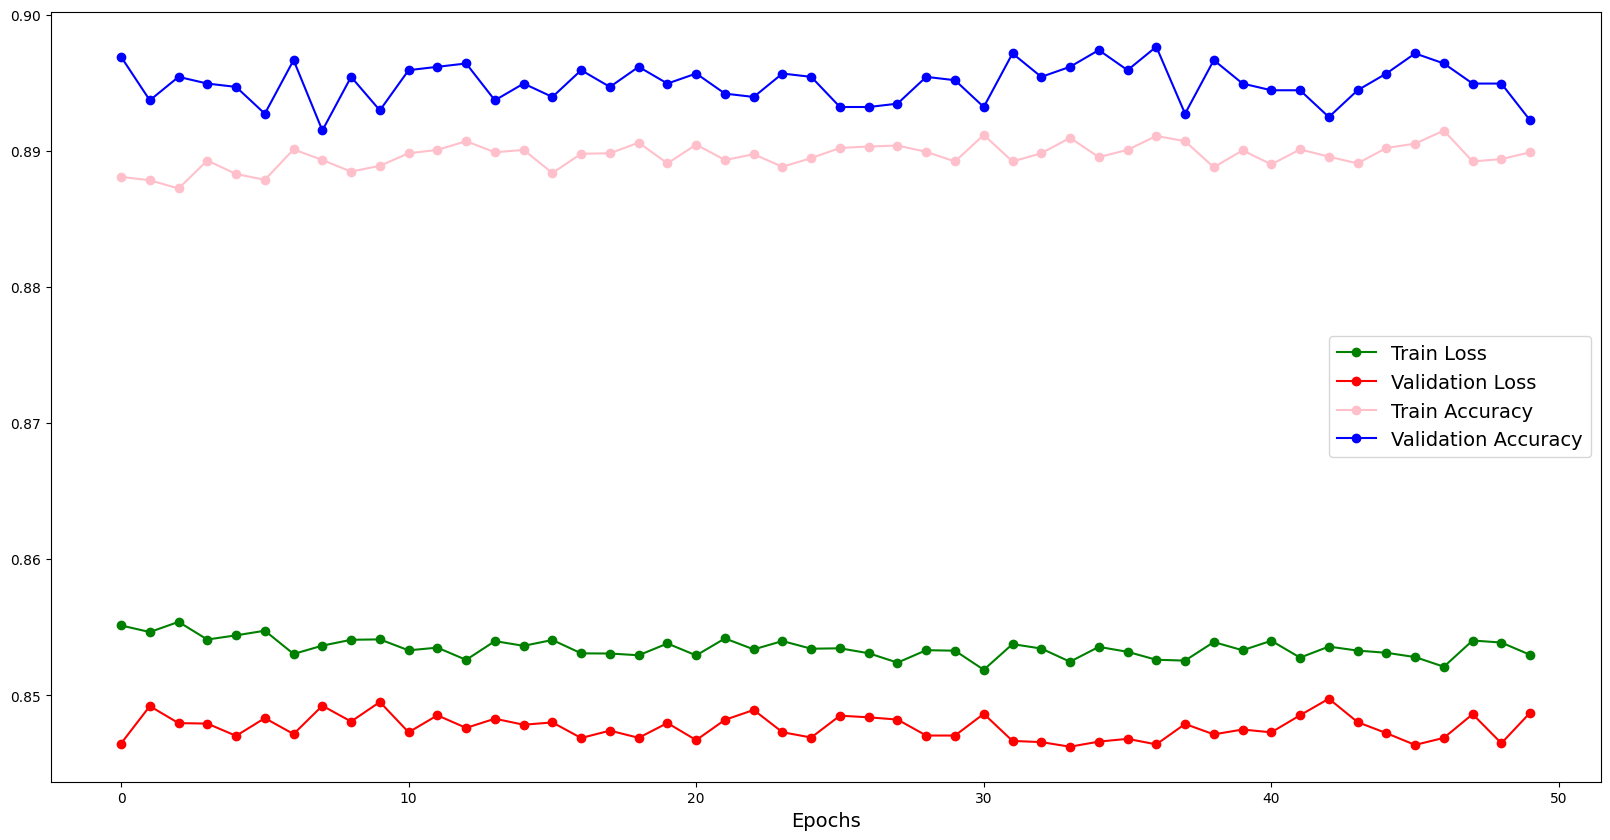

In [ ]:
history = pickle.load(open("{x}_history.pickle".format(x = config['name']), "rb"))
plot_history(history, config['name'])

In [ ]:
dict_ = pickle.load(open("{x}_prediction.pickle".format(x = config['name']), "rb"))
report = classification_report(dict_['y_true'] , dict_['y_pred'])
print(report)


              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97      3030
         1.0       0.83      0.95      0.89      3030
         2.0       0.88      0.97      0.92      1414
         3.0       0.00      0.00      0.00       606

    accuracy                           0.89      8080
   macro avg       0.67      0.72      0.69      8080
weighted avg       0.83      0.89      0.86      8080



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SMOTE-Balanced Training

In [ ]:
config['tr_path'] = 'Data/df_tr_smote.csv'
config['name'] = 'smote'

df_tr = pd.read_csv(config['tr_path'])

y = np.array(df_tr.iloc[:, -1])


mean = torch.tensor(np.mean(df_tr.iloc[: ,:-1], axis=0), dtype = torch.float32)
std = torch.tensor(np.std(df_tr.iloc[: ,:-1], axis=0) , dtype = torch.float32)
print(mean.shape , std.shape)

torch.Size([147]) torch.Size([147])


In [ ]:
if not os.path.exists('smote_model.pt'):
  tr_dataset = MyDataset(path =config ['tr_path'] , mean = mean ,std = std , apply_transform = True)
  tr_loader = DataLoader(tr_dataset, batch_size=config['BATCH_SIZE'], shuffle=True)

  val_dataset = MyDataset(path = config['val_path'] , mean = mean ,std = std, apply_transform = True)
  val_loader = DataLoader(val_dataset, batch_size=config['BATCH_SIZE'], shuffle=True)

  X,Y = next(iter(tr_loader))
  print(X.shape , Y.shape)

  obj = Train_Eval(model=model, model_name=config['name'] ,device=device ,train_loader=tr_loader,
                 val_loader=val_loader, optimizer=optimizer, criterion=criterion, lr_scheduler= lr_scheduler)
  obj.run(config['EPOCHS'])
  obj.eval(df_tst, mean, std)


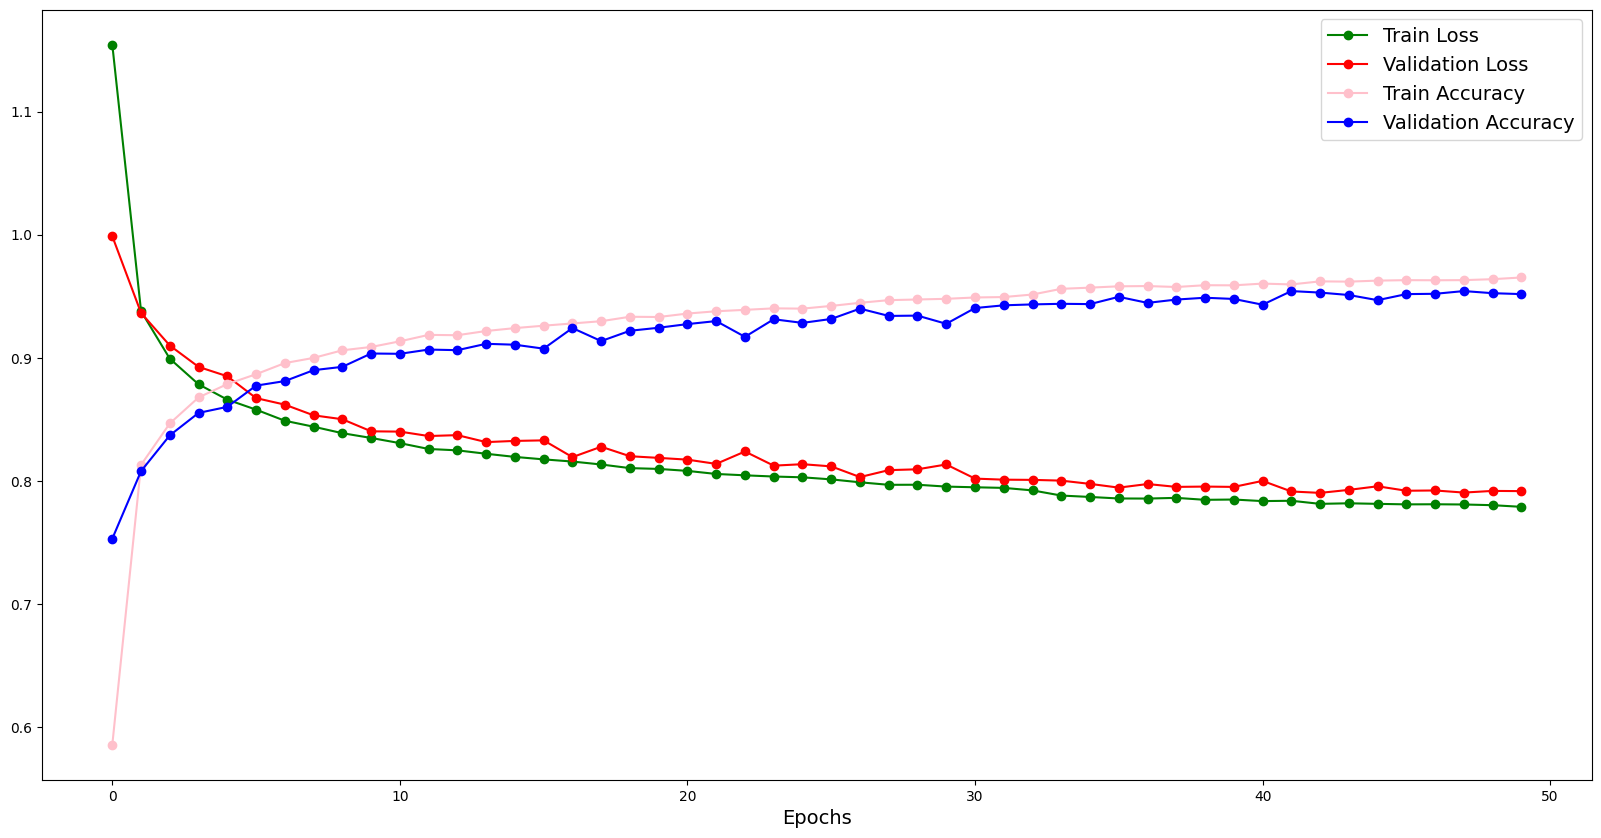

In [ ]:
history = pickle.load(open("{x}_history.pickle".format(x = config['name']), "rb"))
plot_history(history, config['name'])

In [ ]:
dict_ = pickle.load(open("{x}_prediction.pickle".format(x = config['name']), "rb"))
report = classification_report(dict_['y_true'] , dict_['y_pred'])
print(report)

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96      3030
         1.0       0.96      0.91      0.93      3030
         2.0       0.96      0.98      0.97      1414
         3.0       0.82      0.96      0.89       606

    accuracy                           0.95      8080
   macro avg       0.93      0.95      0.94      8080
weighted avg       0.95      0.95      0.95      8080



## Adasyn-Data Training

In [ ]:
config['tr_path'] = 'Data/df_tr_adasyn.csv'
config['name'] = 'adasyn'

df_tr = pd.read_csv(config['tr_path'])

y = np.array(df_tr.iloc[:, -1])


mean = torch.tensor(np.mean(df_tr.iloc[: ,:-1], axis=0), dtype = torch.float32)
std = torch.tensor(np.std(df_tr.iloc[: ,:-1], axis=0) , dtype = torch.float32)
print(mean.shape , std.shape)

torch.Size([147]) torch.Size([147])


In [ ]:
if not os.path.exists('adasyn_model.pt'):
  tr_dataset = MyDataset(path =config ['tr_path'] , mean = mean ,std = std , apply_transform = True)
  tr_loader = DataLoader(tr_dataset, batch_size=config['BATCH_SIZE'], shuffle=True)

  val_dataset = MyDataset(path = config['val_path'] , mean = mean ,std = std, apply_transform = True)
  val_loader = DataLoader(val_dataset, batch_size=config['BATCH_SIZE'], shuffle=True)

  X,Y = next(iter(tr_loader))
  print(X.shape , Y.shape)

  obj = Train_Eval(model=model, model_name=config['name'] ,device=device ,train_loader=tr_loader,
                 val_loader=val_loader, optimizer=optimizer, criterion=criterion, lr_scheduler= lr_scheduler)
  obj.run(config['EPOCHS'])
  obj.eval(df_tst, mean, std)


torch.Size([32, 147]) torch.Size([32])

Epoch: 0


100%|██████████| 127/127 [00:00<00:00, 308.64it/s]


Epoch [0] --> LossTr: 1.1533    AccTr: 0.5892    lossVal : 1.0064     accVal : 0.7419

Detected network improvement, saving current model  "✅"

Epoch: 1


100%|██████████| 127/127 [00:00<00:00, 524.41it/s]


Epoch [1] --> LossTr: 0.9492    AccTr: 0.7995    lossVal : 0.9547     accVal : 0.7916

Detected network improvement, saving current model  "✅"

Epoch: 2


100%|██████████| 127/127 [00:00<00:00, 473.09it/s]


Epoch [2] --> LossTr: 0.9139    AccTr: 0.8318    lossVal : 0.9228     accVal : 0.8241

Detected network improvement, saving current model  "✅"

Epoch: 3


100%|██████████| 127/127 [00:00<00:00, 489.16it/s]


Epoch [3] --> LossTr: 0.8946    AccTr: 0.8503    lossVal : 0.9121     accVal : 0.8332

Detected network improvement, saving current model  "✅"

Epoch: 4


100%|██████████| 127/127 [00:00<00:00, 494.54it/s]


Epoch [4] --> LossTr: 0.8833    AccTr: 0.8622    lossVal : 0.9066     accVal : 0.8391


Epoch: 5


100%|██████████| 127/127 [00:00<00:00, 493.75it/s]


Epoch [5] --> LossTr: 0.8754    AccTr: 0.8688    lossVal : 0.8871     accVal : 0.8558

Detected network improvement, saving current model  "✅"

Epoch: 6


100%|██████████| 127/127 [00:00<00:00, 515.92it/s]


Epoch [6] --> LossTr: 0.8663    AccTr: 0.8785    lossVal : 0.8788     accVal : 0.8612


Epoch: 7


100%|██████████| 127/127 [00:00<00:00, 379.47it/s]


Epoch [7] --> LossTr: 0.8600    AccTr: 0.8840    lossVal : 0.8746     accVal : 0.8676

Detected network improvement, saving current model  "✅"

Epoch: 8


100%|██████████| 127/127 [00:00<00:00, 527.10it/s]


Epoch [8] --> LossTr: 0.8555    AccTr: 0.8881    lossVal : 0.8651     accVal : 0.8780


Epoch: 9


100%|██████████| 127/127 [00:00<00:00, 318.56it/s]


Epoch [9] --> LossTr: 0.8492    AccTr: 0.8946    lossVal : 0.8578     accVal : 0.8875

Detected network improvement, saving current model  "✅"

Epoch: 10


100%|██████████| 127/127 [00:00<00:00, 533.92it/s]


Epoch [10] --> LossTr: 0.8469    AccTr: 0.8965    lossVal : 0.8596     accVal : 0.8816


Epoch: 11


100%|██████████| 127/127 [00:00<00:00, 541.95it/s]


Epoch [11] --> LossTr: 0.8432    AccTr: 0.9009    lossVal : 0.8519     accVal : 0.8922


Epoch: 12


100%|██████████| 127/127 [00:00<00:00, 522.10it/s]


Epoch [12] --> LossTr: 0.8393    AccTr: 0.9038    lossVal : 0.8566     accVal : 0.8836


Epoch: 13


100%|██████████| 127/127 [00:00<00:00, 511.05it/s]


Epoch [13] --> LossTr: 0.8374    AccTr: 0.9061    lossVal : 0.8469     accVal : 0.8974

Detected network improvement, saving current model  "✅"

Epoch: 14


100%|██████████| 127/127 [00:00<00:00, 529.20it/s]


Epoch [14] --> LossTr: 0.8335    AccTr: 0.9102    lossVal : 0.8447     accVal : 0.8996


Epoch: 15


100%|██████████| 127/127 [00:00<00:00, 539.98it/s]


Epoch [15] --> LossTr: 0.8319    AccTr: 0.9112    lossVal : 0.8396     accVal : 0.9062


Epoch: 16


100%|██████████| 127/127 [00:00<00:00, 462.91it/s]


Epoch [16] --> LossTr: 0.8287    AccTr: 0.9150    lossVal : 0.8407     accVal : 0.9060


Epoch: 17


100%|██████████| 127/127 [00:00<00:00, 489.92it/s]


Epoch [17] --> LossTr: 0.8262    AccTr: 0.9167    lossVal : 0.8341     accVal : 0.9097

Detected network improvement, saving current model  "✅"

Epoch: 18


100%|██████████| 127/127 [00:00<00:00, 375.94it/s]


Epoch [18] --> LossTr: 0.8238    AccTr: 0.9204    lossVal : 0.8271     accVal : 0.9173


Epoch: 19


100%|██████████| 127/127 [00:00<00:00, 536.34it/s]


Epoch [19] --> LossTr: 0.8216    AccTr: 0.9219    lossVal : 0.8254     accVal : 0.9198


Epoch: 20


100%|██████████| 127/127 [00:00<00:00, 514.99it/s]


Epoch [20] --> LossTr: 0.8215    AccTr: 0.9221    lossVal : 0.8330     accVal : 0.9102


Epoch: 21


100%|██████████| 127/127 [00:00<00:00, 530.55it/s]


Epoch [21] --> LossTr: 0.8214    AccTr: 0.9217    lossVal : 0.8256     accVal : 0.9173


Epoch: 22


100%|██████████| 127/127 [00:00<00:00, 491.89it/s]


Epoch [22] --> LossTr: 0.8180    AccTr: 0.9255    lossVal : 0.8209     accVal : 0.9240

Detected network improvement, saving current model  "✅"

Epoch: 23


100%|██████████| 127/127 [00:00<00:00, 538.49it/s]


Epoch [23] --> LossTr: 0.8155    AccTr: 0.9278    lossVal : 0.8314     accVal : 0.9122


Epoch: 24


100%|██████████| 127/127 [00:00<00:00, 519.17it/s]


Epoch [24] --> LossTr: 0.8156    AccTr: 0.9276    lossVal : 0.8189     accVal : 0.9264


Epoch: 25


100%|██████████| 127/127 [00:00<00:00, 515.25it/s]


Epoch [25] --> LossTr: 0.8138    AccTr: 0.9296    lossVal : 0.8225     accVal : 0.9220


Epoch: 26


100%|██████████| 127/127 [00:00<00:00, 511.67it/s]


Epoch [26] --> LossTr: 0.8116    AccTr: 0.9313    lossVal : 0.8219     accVal : 0.9227


Epoch: 27


100%|██████████| 127/127 [00:00<00:00, 343.46it/s]


Epoch [27] --> LossTr: 0.8101    AccTr: 0.9336    lossVal : 0.8143     accVal : 0.9296


Epoch: 28


100%|██████████| 127/127 [00:00<00:00, 529.34it/s]


Epoch [28] --> LossTr: 0.8083    AccTr: 0.9358    lossVal : 0.8173     accVal : 0.9245


Epoch: 29


100%|██████████| 127/127 [00:00<00:00, 460.97it/s]


Epoch [29] --> LossTr: 0.8074    AccTr: 0.9365    lossVal : 0.8172     accVal : 0.9272


Epoch: 30


100%|██████████| 127/127 [00:00<00:00, 531.01it/s]


Epoch [30] --> LossTr: 0.8050    AccTr: 0.9386    lossVal : 0.8182     accVal : 0.9254


Epoch: 31


100%|██████████| 127/127 [00:00<00:00, 529.80it/s]


Epoch [31] --> LossTr: 0.8046    AccTr: 0.9389    lossVal : 0.8111     accVal : 0.9333


Epoch: 32


100%|██████████| 127/127 [00:00<00:00, 518.01it/s]


Epoch [32] --> LossTr: 0.8018    AccTr: 0.9418    lossVal : 0.8068     accVal : 0.9375

Detected network improvement, saving current model  "✅"

Epoch: 33


100%|██████████| 127/127 [00:00<00:00, 501.72it/s]


Epoch [33] --> LossTr: 0.8016    AccTr: 0.9425    lossVal : 0.8091     accVal : 0.9323


Epoch: 34


100%|██████████| 127/127 [00:00<00:00, 481.04it/s]


Epoch [34] --> LossTr: 0.8016    AccTr: 0.9419    lossVal : 0.8017     accVal : 0.9412


Epoch: 35


100%|██████████| 127/127 [00:00<00:00, 522.59it/s]


Epoch [35] --> LossTr: 0.7950    AccTr: 0.9492    lossVal : 0.8062     accVal : 0.9375


Epoch: 36


100%|██████████| 127/127 [00:00<00:00, 368.21it/s]


Epoch [36] --> LossTr: 0.7937    AccTr: 0.9502    lossVal : 0.8015     accVal : 0.9424


Epoch: 37


100%|██████████| 127/127 [00:00<00:00, 501.53it/s]


Epoch [37] --> LossTr: 0.7930    AccTr: 0.9513    lossVal : 0.8070     accVal : 0.9355


Epoch: 38


100%|██████████| 127/127 [00:00<00:00, 543.52it/s]


Epoch [38] --> LossTr: 0.7917    AccTr: 0.9519    lossVal : 0.7994     accVal : 0.9446


Epoch: 39


100%|██████████| 127/127 [00:00<00:00, 531.07it/s]


Epoch [39] --> LossTr: 0.7917    AccTr: 0.9526    lossVal : 0.7987     accVal : 0.9454


Epoch: 40


100%|██████████| 127/127 [00:00<00:00, 523.76it/s]


Epoch [40] --> LossTr: 0.7908    AccTr: 0.9530    lossVal : 0.7964     accVal : 0.9464

Detected network improvement, saving current model  "✅"

Epoch: 41


100%|██████████| 127/127 [00:00<00:00, 492.09it/s]


Epoch [41] --> LossTr: 0.7897    AccTr: 0.9547    lossVal : 0.8001     accVal : 0.9437


Epoch: 42


100%|██████████| 127/127 [00:00<00:00, 498.59it/s]


Epoch [42] --> LossTr: 0.7887    AccTr: 0.9555    lossVal : 0.8009     accVal : 0.9407


Epoch: 43


100%|██████████| 127/127 [00:00<00:00, 527.61it/s]


Epoch [43] --> LossTr: 0.7872    AccTr: 0.9571    lossVal : 0.8008     accVal : 0.9422


Epoch: 44


100%|██████████| 127/127 [00:00<00:00, 497.84it/s]


Epoch [44] --> LossTr: 0.7857    AccTr: 0.9586    lossVal : 0.7946     accVal : 0.9493


Epoch: 45


100%|██████████| 127/127 [00:00<00:00, 349.41it/s]


Epoch [45] --> LossTr: 0.7864    AccTr: 0.9578    lossVal : 0.7958     accVal : 0.9478


Epoch: 46


100%|██████████| 127/127 [00:00<00:00, 517.50it/s]


Epoch [46] --> LossTr: 0.7866    AccTr: 0.9574    lossVal : 0.7938     accVal : 0.9493


Epoch: 47


100%|██████████| 127/127 [00:00<00:00, 475.04it/s]


Epoch [47] --> LossTr: 0.7861    AccTr: 0.9583    lossVal : 0.7951     accVal : 0.9478


Epoch: 48


100%|██████████| 127/127 [00:00<00:00, 472.59it/s]


Epoch [48] --> LossTr: 0.7851    AccTr: 0.9587    lossVal : 0.7937     accVal : 0.9498


Epoch: 49


100%|██████████| 127/127 [00:00<00:00, 528.79it/s]


Epoch [49] --> LossTr: 0.7858    AccTr: 0.9584    lossVal : 0.7956     accVal : 0.9473

acc : 0.944678   
{0: 3030, 1: 3030, 2: 1414, 3: 606}


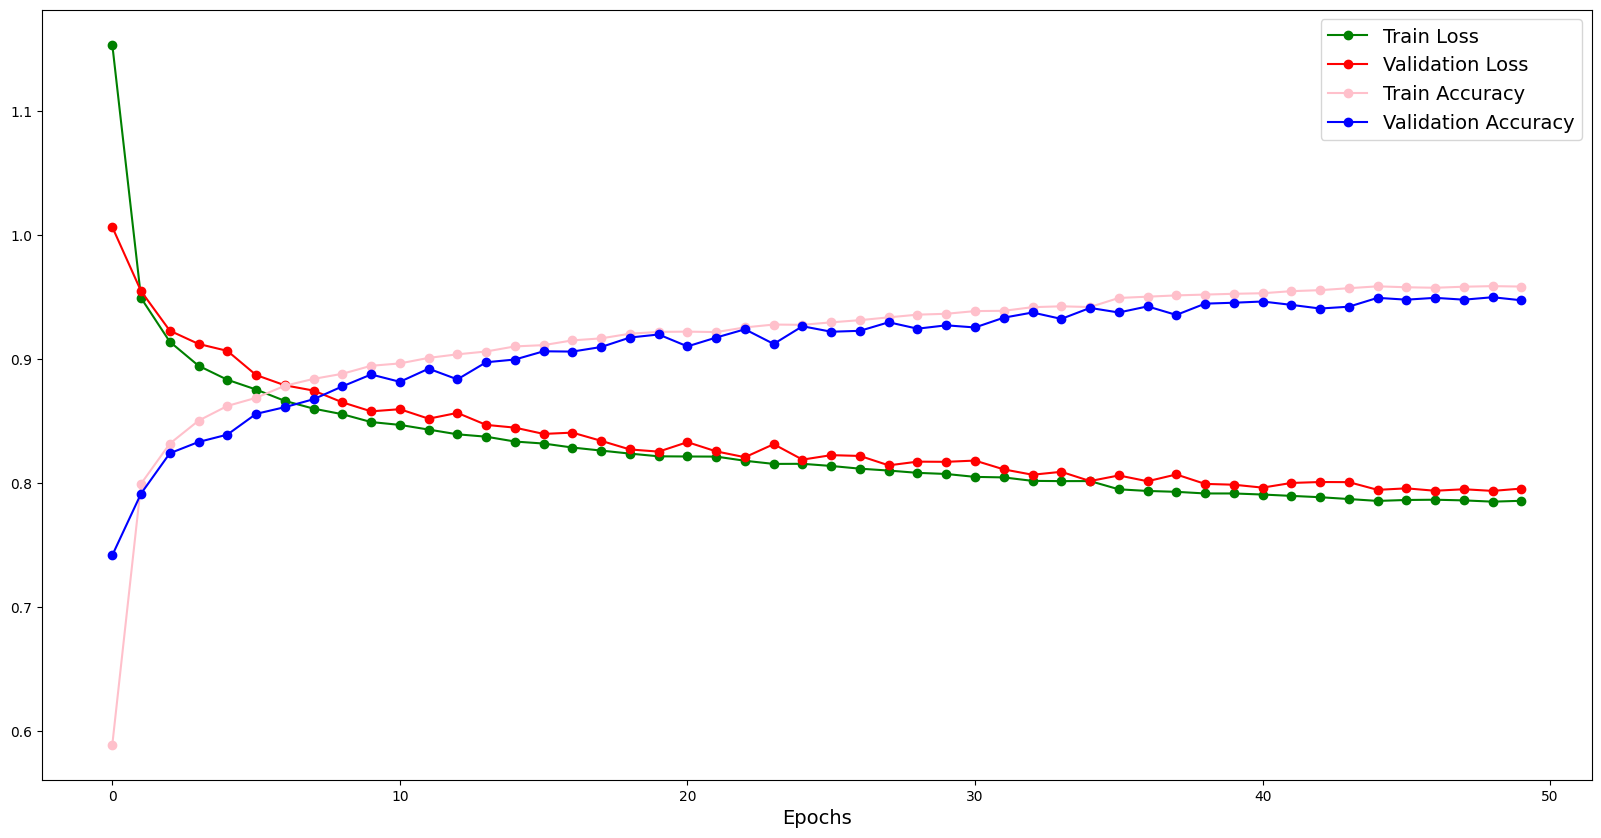

In [ ]:
history = pickle.load(open("{x}_history.pickle".format(x = config['name']), "rb"))
plot_history(history, config['name'])

In [ ]:
dict_ = pickle.load(open("{x}_prediction.pickle".format(x = config['name']), "rb"))
report = classification_report(dict_['y_true'] , dict_['y_pred'])
print(report)

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97      3030
         1.0       0.97      0.89      0.93      3030
         2.0       0.96      0.98      0.97      1414
         3.0       0.80      0.97      0.88       606

    accuracy                           0.94      8080
   macro avg       0.92      0.95      0.93      8080
weighted avg       0.95      0.94      0.94      8080

